In [ ]:
!pip install pyspark folium


import os
import json
import gc
import zipfile
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans as SklearnKMeans
import folium
from folium.plugins import HeatMap, MarkerCluster


from pyspark.sql import SparkSession

from pyspark.sql.functions import (
    col, to_timestamp, hour, dayofweek, month, 
    avg, count, log1p, date_format, when, lit,
    radians as to_radians,  
    degrees as to_degrees,  
    sin, cos, atan2, sqrt, pow, 
    abs as spark_abs, 
    expm1
)


from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, VectorSlicer
from pyspark.ml.clustering import KMeans
from pyspark.ml.regression import GBTRegressor, LinearRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.stat import Correlation
import warnings
warnings.filterwarnings('ignore')

# Setting Tampilan
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print("✅ Environment Kaggle Siap & Library Terinstall!")

✅ Environment Kaggle Siap & Library Terinstall!


In [2]:
# Inisialisasi Spark
try:
    spark
except NameError:
    print("🔄 Menjalankan Spark Session...")
    spark = SparkSession.builder \
        .appName("NYCTaxi_Full") \
        .config("spark.driver.memory", "12g") \
        .getOrCreate()
    print("✅ Spark Session Berhasil!")

# hanya muncul kalau ada error fatal
spark.sparkContext.setLogLevel("ERROR")

🔄 Menjalankan Spark Session...


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/12 15:49:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Spark Session Berhasil!


### 1. Load Data

In [ ]:
import os
import zipfile

print("\n📂 Menyiapkan Data (Train & Test)...")

# Daftar file yang mau diproses
files = ['train', 'test']
working_dir = '/kaggle/working/'

for name in files:
    input_zip = f'/kaggle/input/nyc-taxi-trip-duration/{name}.zip'
    working_csv = f'/kaggle/working/{name}.csv'

    # Ekstraksi Data
    if os.path.exists(input_zip) and not os.path.exists(working_csv):
        print(f"   - Mengekstrak {name}.zip...")
        with zipfile.ZipFile(input_zip, 'r') as z:
            z.extractall(working_dir)
        print(f"   ✅ {name} Ekstraksi Selesai.")
        
    elif not os.path.exists(working_csv):
        print(f"   ⚠️ {name}.zip tidak ditemukan di Input. Mencoba download via API...")
        os.system("kaggle competitions download -c nyc-taxi-trip-duration")
        os.system("unzip -q nyc-taxi-trip-duration.zip") 
        os.system(f"unzip -q {name}.zip")

# Load Data ke Spark
print("\n⏳ Loading ke Spark DataFrame...")

# Load Train
if os.path.exists(f'{working_dir}train.csv'):
    df = spark.read.csv(f'{working_dir}train.csv', header=True, inferSchema=True)
    print(f"✅ DF Train Loaded: {df.count():,} baris.")
else:
    raise FileNotFoundError("❌ File train.csv gagal dimuat!")

# Load Test
if os.path.exists(f'{working_dir}test.csv'):
    df_test = spark.read.csv(f'{working_dir}test.csv', header=True, inferSchema=True)
    print(f"✅ DF Test Loaded : {df_test.count():,} baris.")
else:
    raise FileNotFoundError("❌ File test.csv gagal dimuat!")

print("\n🚀 Semua data siap digunakan!")


📂 Menyiapkan Data (Train & Test)...
   - Mengekstrak train.zip...
   ✅ train Ekstraksi Selesai.
   - Mengekstrak test.zip...
   ✅ test Ekstraksi Selesai.

⏳ Loading ke Spark DataFrame...


✅ DF Train Loaded: 1,458,644 baris.


✅ DF Test Loaded : 625,134 baris.

🚀 Semua data siap digunakan!


In [4]:
# Caching agar proses selanjutnya lebih cepat
df.cache()

print(f"Total Baris Data Awal: {df.count()}")
df.printSchema()

Total Baris Data Awal: 1458644
root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)



### 2. Data Cleaning & Preprocessing

In [5]:
# Konversi string ke timestamp
df = df.withColumn("pickup_datetime", to_timestamp(col("pickup_datetime"))) \
       .withColumn("dropoff_datetime", to_timestamp(col("dropoff_datetime")))

# Cek hasil konversi
df.select("pickup_datetime", "dropoff_datetime").show(5)

+-------------------+-------------------+
|    pickup_datetime|   dropoff_datetime|
+-------------------+-------------------+
|2016-03-14 17:24:55|2016-03-14 17:32:30|
|2016-06-12 00:43:35|2016-06-12 00:54:38|
|2016-01-19 11:35:24|2016-01-19 12:10:48|
|2016-04-06 19:32:31|2016-04-06 19:39:40|
|2016-03-26 13:30:55|2016-03-26 13:38:10|
+-------------------+-------------------+
only showing top 5 rows



In [6]:
initial_count = df.count()

# Hapus duplikat
df = df.dropDuplicates()
print(f'Jumlah duplikat yang dibuang: {initial_count - df.count()}')

# Hapus Null values
df = df.na.drop()
print("Null values dibersihkan.")

Jumlah duplikat yang dibuang: 0
Null values dibersihkan.


In [ ]:
# Hitung durasi dalam menit
df = df.withColumn("trip_duration_minutes", col("trip_duration") / 60)

# Statistik sebelum filter 
print("Statistik Durasi (Menit) Sebelum Filter:")
df.select("trip_duration_minutes").describe().show()

# Filter Durasi (1 menit s/d 120 menit)
df = df.filter((col("trip_duration_minutes") >= 1) & (col("trip_duration_minutes") <= 120))

# Filter Penumpang (1 - 6 orang)
df = df.filter((col("passenger_count") >= 1) & (col("passenger_count") <= 6))

print(f"Sisa data setelah filter durasi & penumpang: {df.count()}")

Statistik Durasi (Menit) Sebelum Filter:


+-------+---------------------+
|summary|trip_duration_minutes|
+-------+---------------------+
|  count|              1458644|
|   mean|   15.991537882672606|
| stddev|    87.29052874162763|
|    min| 0.016666666666666666|
|    max|    58771.36666666667|
+-------+---------------------+



Sisa data setelah filter durasi & penumpang: 1447777


In [8]:
print("--- [4] Filter Area Koordinat (NYC) ---")

# Batas koordinat NYC (Manhattan & sekitarnya)
lat_min, lat_max = 40.5, 41.0
lon_min, lon_max = -74.5, -73.0

df = df.filter(
    (col('pickup_latitude').between(lat_min, lat_max)) &
    (col('dropoff_latitude').between(lat_min, lat_max)) &
    (col('pickup_longitude').between(lon_min, lon_max)) &
    (col('dropoff_longitude').between(lon_min, lon_max))
)

# Hapus data dimana pickup == dropoff (diam di tempat)
df = df.filter(~((col('pickup_longitude') == col('dropoff_longitude')) & 
                 (col('pickup_latitude') == col('dropoff_latitude'))))

print("Filter area selesai.")

--- [4] Filter Area Koordinat (NYC) ---
Filter area selesai.


In [9]:
# Fungsi Haversine
def spark_haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius Bumi (km)
    # Konversi ke radian
    lat1, lon1, lat2, lon2 = to_radians(lat1), to_radians(lon1), to_radians(lat2), to_radians(lon2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = pow(sin(dlat / 2), 2) + cos(lat1) * cos(lat2) * pow(sin(dlon / 2), 2)
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Terapkan fungsi
df = df.withColumn("distance_km", spark_haversine(
    col("pickup_latitude"), col("pickup_longitude"),
    col("dropoff_latitude"), col("dropoff_longitude")
))

# Hitung Kecepatan Rata-rata (km/h)
df = df.withColumn("avg_speed_kmh", col("distance_km") / (col("trip_duration_minutes") / 60))

# Filter Jarak (0.5km - 30km) & Kecepatan (0.5 - 120 km/h)
df = df.filter((col("distance_km") >= 0.5) & (col("distance_km") <= 30))
df = df.filter((col("avg_speed_kmh") > 0.5) & (col("avg_speed_kmh") <= 120))

print(f'✅ Data shape setelah cleaning total: {df.count()} baris')

✅ Data shape setelah cleaning total: 1406483 baris


### 3. EDA

(0.0, 120.0)

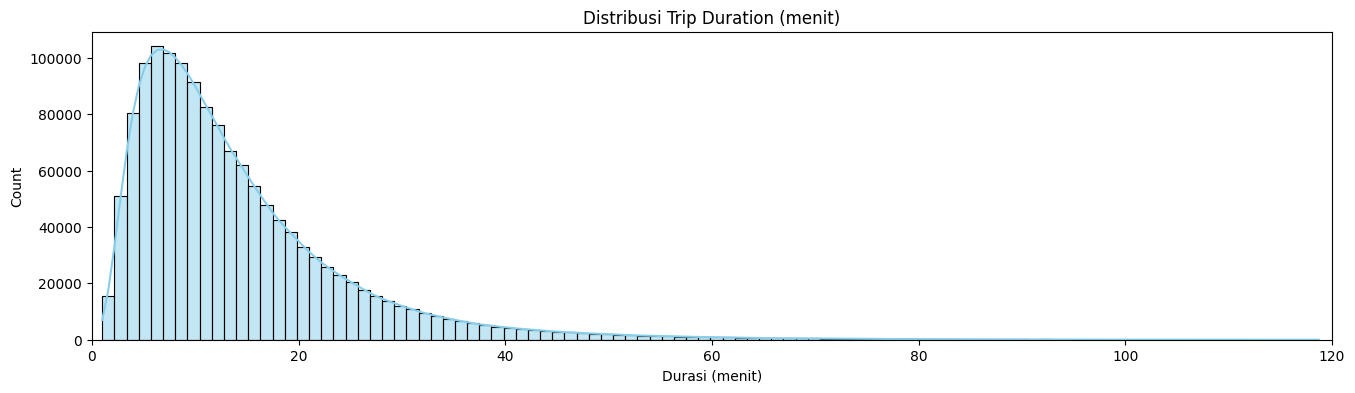

In [10]:
dur_dist_pd = df.select("trip_duration_minutes", "distance_km").toPandas()

plt.figure(figsize=(16, 4))

sns.histplot(dur_dist_pd['trip_duration_minutes'], bins=100, kde=True, color='skyblue')
plt.title('Distribusi Trip Duration (menit)')
plt.xlabel('Durasi (menit)')
plt.xlim(0, 120)

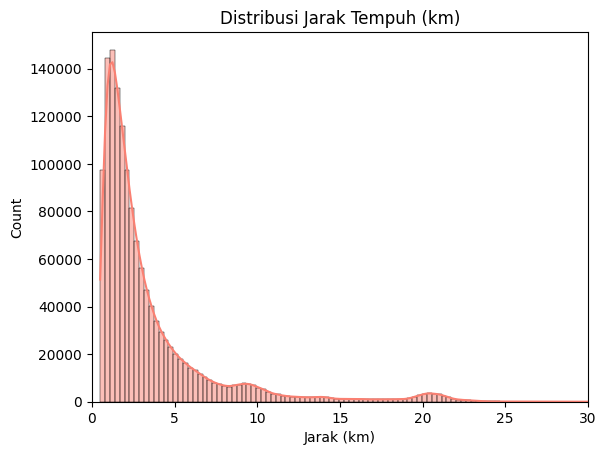

222

In [11]:
sns.histplot(dur_dist_pd['distance_km'], bins=100, kde=True, color='salmon')
plt.title('Distribusi Jarak Tempuh (km)')
plt.xlabel('Jarak (km)')
plt.xlim(0, 30)

plt.show()

# Hapus variabel pandas untuk hemat memori
del dur_dist_pd
gc.collect()

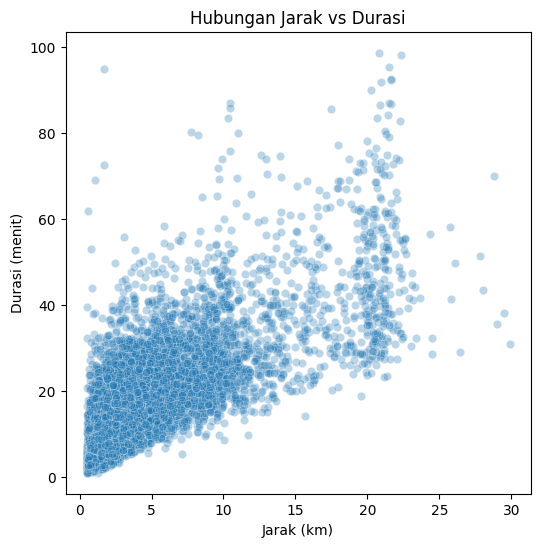

In [12]:
# Sample sekitar 14,000 data (14,000 / 1.4jt ~= 0.01)
scatter_pd = df.select("distance_km", "trip_duration_minutes").sample(withReplacement=False, fraction=0.01, seed=42).toPandas()

plt.figure(figsize=(6, 6))
sns.scatterplot(x='distance_km', y='trip_duration_minutes', data=scatter_pd, alpha=0.3)
plt.title('Hubungan Jarak vs Durasi')
plt.xlabel('Jarak (km)')
plt.ylabel('Durasi (menit)')
plt.show()

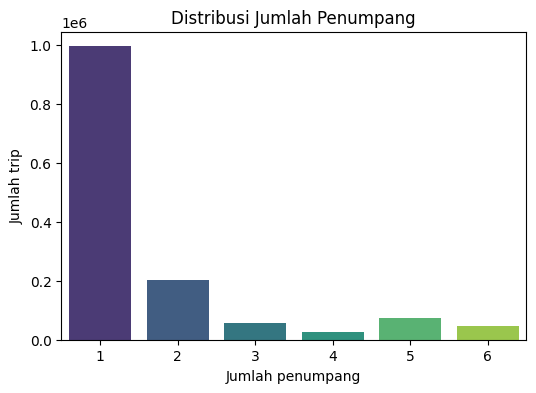

In [ ]:
pass_counts = df.groupBy("passenger_count").count().orderBy("passenger_count").toPandas()

plt.figure(figsize=(6, 4))
sns.barplot(x='passenger_count', y='count', data=pass_counts, palette='viridis')
plt.title('Distribusi Jumlah Penumpang')
plt.xlabel('Jumlah penumpang')
plt.ylabel('Jumlah trip')
plt.show()

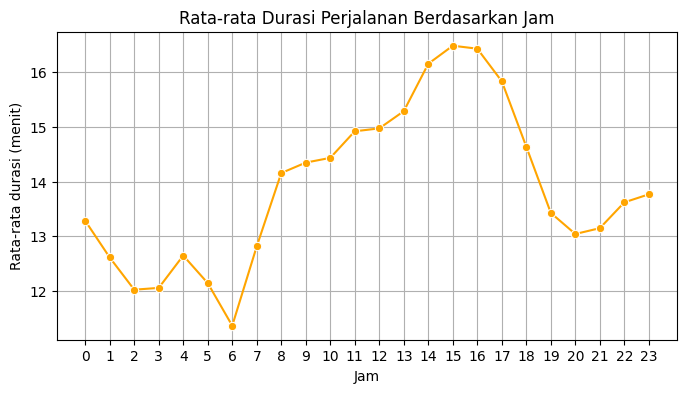

In [ ]:
from pyspark.sql.functions import hour, col

df = df.withColumn("pickup_hour", hour(col("pickup_datetime")))

hourly_mean = df.groupBy("pickup_hour") \
    .agg(avg("trip_duration_minutes").alias("mean_duration")) \
    .orderBy("pickup_hour") \
    .toPandas()

plt.figure(figsize=(8, 4))
sns.lineplot(x=hourly_mean['pickup_hour'], y=hourly_mean['mean_duration'], marker='o', color='orange')
plt.title('Rata-rata Durasi Perjalanan Berdasarkan Jam')
plt.xlabel('Jam')
plt.ylabel('Rata-rata durasi (menit)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

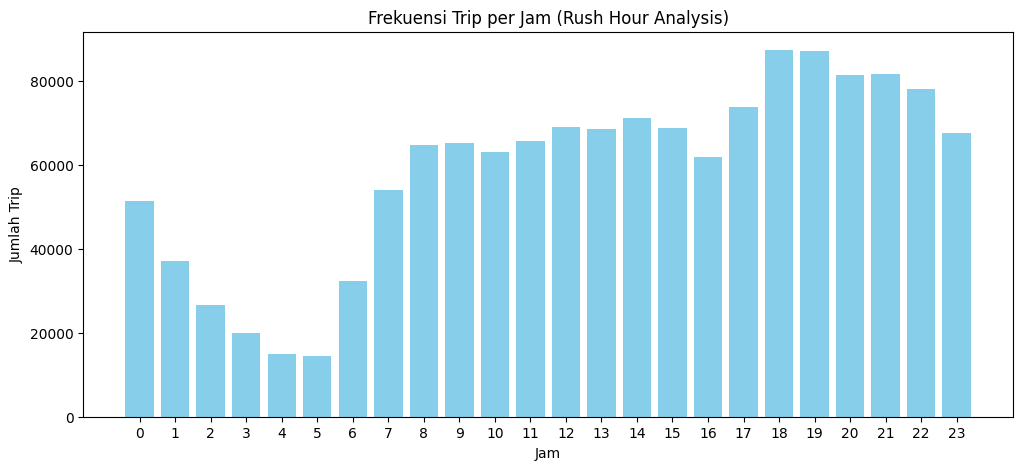

In [ ]:
freq_per_hour = df.groupBy("pickup_hour").count().orderBy("pickup_hour").toPandas()

plt.figure(figsize=(12, 5))
plt.bar(freq_per_hour['pickup_hour'], freq_per_hour['count'], color='skyblue')
plt.title("Frekuensi Trip per Jam (Rush Hour Analysis)")
plt.xlabel("Jam")
plt.ylabel("Jumlah Trip")
plt.xticks(range(0, 24))
plt.show()

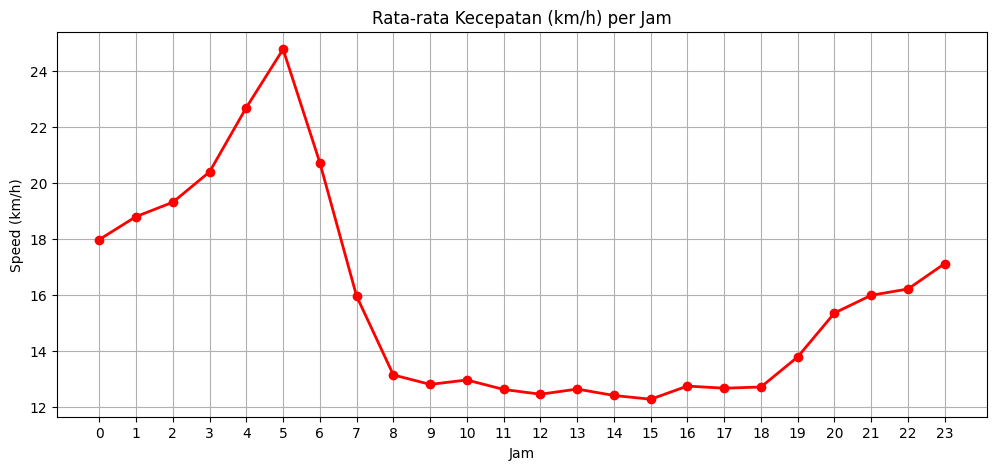

In [16]:
avg_speed_hour = df.groupBy("pickup_hour").agg(avg("avg_speed_kmh").alias("mean_speed")) \
                   .orderBy("pickup_hour").toPandas()

plt.figure(figsize=(12, 5))
plt.plot(avg_speed_hour['pickup_hour'], avg_speed_hour['mean_speed'], marker='o', color='red', linewidth=2)
plt.title("Rata-rata Kecepatan (km/h) per Jam")
plt.xlabel("Jam")
plt.ylabel("Speed (km/h)")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

Visualisasi Boxplot Hari vs Durasi...


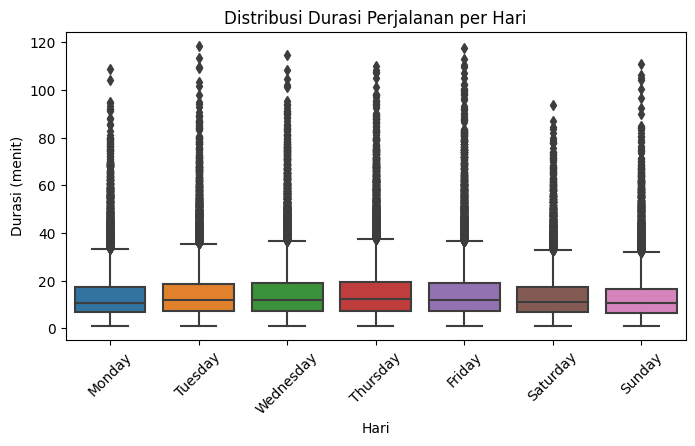

In [ ]:
from pyspark.sql.functions import date_format, col

print("Visualisasi Boxplot Hari vs Durasi...")

# "EEEE" = "Monday", "Tuesday"
df = df.withColumn("pickup_dayofweek", date_format(col("pickup_datetime"), "EEEE"))

# pakai sample 10% 
boxplot_data = df.select("pickup_dayofweek", "trip_duration_minutes") \
                 .sample(fraction=0.1, seed=42) \
                 .toPandas()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(8, 4))
sns.boxplot(x='pickup_dayofweek', y='trip_duration_minutes', data=boxplot_data, order=day_order)
plt.title('Distribusi Durasi Perjalanan per Hari')
plt.xlabel('Hari')
plt.ylabel('Durasi (menit)')
plt.xticks(rotation=45)
plt.show()

Visualisasi Heatmap Korelasi...


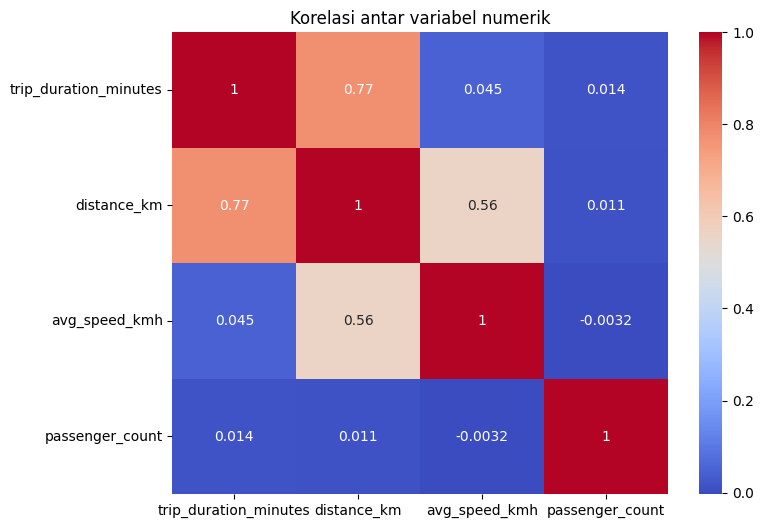

In [ ]:
print("Visualisasi Heatmap Korelasi...")

numeric_cols = ['trip_duration_minutes', 'distance_km', 'avg_speed_kmh', 'passenger_count']

# Gabung jadi satu kolom vektor
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
corr_data = assembler.transform(df).select("features")

# Hitung Matriks Korelasi di Spark
pearson_corr = Correlation.corr(corr_data, "features").head()
corr_matrix = pearson_corr[0].toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', 
            xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title('Korelasi antar variabel numerik')
plt.show()

In [ ]:
print("Visualisasi Peta Heatmap (Folium)...")


heat_data_spark = df.select("pickup_latitude", "pickup_longitude") \
                    .sample(withReplacement=False, fraction=0.007, seed=42) \
                    .collect()

heat_data_list = [[row['pickup_latitude'], row['pickup_longitude']] for row in heat_data_spark]

m = folium.Map(location=[40.75, -73.97], zoom_start=11)
HeatMap(heat_data_list, radius=10).add_to(m)

m

Visualisasi Peta Heatmap (Folium)...


In [ ]:
print("Visualisasi Peta Marker Cluster...")

marker_data_spark = df.select("pickup_latitude", "pickup_longitude") \
                      .sample(withReplacement=False, fraction=0.001, seed=42) \
                      .collect()

m2 = folium.Map(location=[40.75, -73.97], zoom_start=11)
cluster = MarkerCluster().add_to(m2)

for row in marker_data_spark:
    folium.Marker([row['pickup_latitude'], row['pickup_longitude']]).add_to(cluster)

m2

Visualisasi Peta Marker Cluster...


### 4. Feature Engineering

In [ ]:
print("🚀 [FE-1] Memulai Feature Engineering: Waktu...")

# Ekstraksi Komponen Waktu Dasar
df = df.withColumn("month", month(col("pickup_datetime")))
df = df.withColumn("day_of_week_idx", dayofweek(col("pickup_datetime"))) 
df = df.withColumn("hour", hour(col("pickup_datetime")))

# Fitur Rush Hour 
from pyspark.sql.functions import when

df = df.withColumn("is_rush_hour", 
                   when(col("hour").isin([8,9,10,15,16,17,18]), 1).otherwise(0))

# Fitur Weekend (Sabtu & Minggu), 1=Minggu, 7=Sabtu
df = df.withColumn("is_weekend", 
                   when(col("day_of_week_idx").isin([1, 7]), 1).otherwise(0))

print("--- Statistik Fitur Waktu ---")
df.select("hour", "month", "is_weekend", "is_rush_hour").describe().show()

print("✅ Fitur Waktu Selesai.")

🚀 [FE-1] Memulai Feature Engineering: Waktu...
--- Statistik Fitur Waktu ---


+-------+------------------+-----------------+-------------------+------------------+
|summary|              hour|            month|         is_weekend|      is_rush_hour|
+-------+------------------+-----------------+-------------------+------------------+
|  count|           1406483|          1406483|            1406483|           1406483|
|   mean|13.621088203696738|3.517275359887037|0.28524553798375096|0.3448296211187764|
| stddev| 6.401204558991685|1.680685927767903|0.45153146734408034|0.4753128592275913|
|    min|                 0|                1|                  0|                 0|
|    max|                23|                6|                  1|                 1|
+-------+------------------+-----------------+-------------------+------------------+

✅ Fitur Waktu Selesai.


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.ml.clustering import KMeans 

print("🚀 [STEP 1] Menyiapkan Data Koordinat Gabungan...")

# Gabung koordinat Pickup & Dropoff
df_pick = df.select(col("pickup_latitude").alias("lat"), col("pickup_longitude").alias("lon"))
df_drop = df.select(col("dropoff_latitude").alias("lat"), col("dropoff_longitude").alias("lon"))
df_all_coords = df_pick.union(df_drop)

# Buat Vector Input 
vec_assembler = VectorAssembler(inputCols=["lat", "lon"], outputCol="features")
df_kmeans_input = vec_assembler.transform(df_all_coords)

print("✅ Data vektor 'df_kmeans_input' siap dianalisis.")

🚀 [STEP 1] Menyiapkan Data Koordinat Gabungan...
✅ Data vektor 'df_kmeans_input' siap dianalisis.


In [ ]:
# # Elbow Method Analysis

# k_range = range(2, 16) 
# costs = []

# print("⏳ Memulai kalkulasi Elbow Method... (Tunggu sebentar)")

# for k in k_range:
#     kmeans = KMeans().setK(k).setSeed(42).setFeaturesCol("features")
    
#     model = kmeans.fit(df_kmeans_input) 
    
#     cost = model.summary.trainingCost
#     costs.append(cost)
#     print(f"   ✅ Selesai K={k} | Cost: {cost:,.0f}")

# plt.figure(figsize=(10, 5))
# plt.plot(k_range, costs, marker='o', linestyle='--', color='blue')
# plt.title('Elbow Method Analysis')
# plt.xlabel('Jumlah Kluster (K)')
# plt.ylabel('Cost / Inertia')
# plt.xticks(k_range)
# plt.grid(True)
# plt.show()

In [ ]:
# Final Clustering Dengan K Terbaik

K_BEST = 10

print(f"🚀 [STEP 3] Menerapkan Final KMeans dengan K={K_BEST}...")

# Training Model Final
kmeans_final = KMeans(k=K_BEST, seed=42, featuresCol="features", predictionCol="cluster")
model_km_final = kmeans_final.fit(df_kmeans_input)

# Terapkan ke Data Utama (Transform)
print("   - Mengupdate kolom cluster di DataFrame utama...")
vec_pick = VectorAssembler(inputCols=["pickup_latitude", "pickup_longitude"], outputCol="pickup_vec")
vec_drop = VectorAssembler(inputCols=["dropoff_latitude", "dropoff_longitude"], outputCol="dropoff_vec")

# Hapus kolom vektor lama 
for col_name in ["pickup_vec", "dropoff_vec"]:
    if col_name in df.columns:
        df = df.drop(col_name)

df = vec_pick.transform(df)
df = vec_drop.transform(df)

# Prediksi Pickup
model_km_final.setFeaturesCol("pickup_vec")
model_km_final.setPredictionCol("pickup_cluster")
df = model_km_final.transform(df)

# Prediksi Dropoff
model_km_final.setFeaturesCol("dropoff_vec")
model_km_final.setPredictionCol("dropoff_cluster")
df = model_km_final.transform(df)

df = df.drop("pickup_vec", "dropoff_vec", "features")
print("🎉 Selesai! Dataframe sekarang punya kolom kluster yang optimal.")

🚀 [STEP 3] Menerapkan Final KMeans dengan K=10...


   - Mengupdate kolom cluster di DataFrame utama...
🎉 Selesai! Dataframe sekarang punya kolom kluster yang optimal.


In [ ]:
print("🚀 [FE-3] Memulai Feature Engineering: One-Hot Encoding...")

# Encoder pakai Cluster (0-14) dan DayOfWeek (1-7)
encoder = OneHotEncoder(
    inputCols=["pickup_cluster", "dropoff_cluster", "day_of_week_idx"],
    outputCols=["pickup_cluster_vec", "dropoff_cluster_vec", "day_vec"],
    dropLast=False 
)

# Fit & Transform
model_enc = encoder.fit(df)
df = model_enc.transform(df)

print("✅ Encoding Selesai. Kolom vector terbentuk: pickup_cluster_vec, dropoff_cluster_vec, day_vec")

🚀 [FE-3] Memulai Feature Engineering: One-Hot Encoding...


✅ Encoding Selesai. Kolom vector terbentuk: pickup_cluster_vec, dropoff_cluster_vec, day_vec


In [ ]:
print("🚀 [FE-4] Memulai Feature Engineering: Matematika Lanjutan...")

# Delta Koordinat
df = df.withColumn("delta_lat", col("dropoff_latitude") - col("pickup_latitude"))
df = df.withColumn("delta_lon", col("dropoff_longitude") - col("pickup_longitude"))

# Manhattan Distance (Abs Delta Lat + Abs Delta Lon)
df = df.withColumn("manhattan_distance", spark_abs(col("delta_lat")) + spark_abs(col("delta_lon")))

# 3. Bearing (Arah Mata Angin)
def spark_bearing(lat1, lon1, lat2, lon2):
    lat1_r, lon1_r, lat2_r, lon2_r = to_radians(lat1), to_radians(lon1), to_radians(lat2), to_radians(lon2)
    d_lon_r = lon2_r - lon1_r
    
    y = sin(d_lon_r) * cos(lat2_r)
    x = cos(lat1_r) * sin(lat2_r) - sin(lat1_r) * cos(lat2_r) * cos(d_lon_r)
    
    # Hasil radian -> derajat -> normalisasi 0-360
    angle = to_degrees(atan2(y, x))
    return (angle + 360) % 360

df = df.withColumn("bearing", spark_bearing(
    col("pickup_latitude"), col("pickup_longitude"),
    col("dropoff_latitude"), col("dropoff_longitude")
))

# Log Distance 
df = df.withColumn("log_distance", log1p(col("distance_km")))

print("--- Statistik Fitur Jarak & Arah ---")
df.select("manhattan_distance", "bearing", "log_distance").describe().show()

print("✅ Fitur Matematika Selesai.")

🚀 [FE-4] Memulai Feature Engineering: Matematika Lanjutan...
--- Statistik Fitur Jarak & Arah ---


+-------+-------------------+------------------+------------------+
|summary| manhattan_distance|           bearing|      log_distance|
+-------+-------------------+------------------+------------------+
|  count|            1406483|           1406483|           1406483|
|   mean|0.04709645011915672|153.40865605918336|1.2891111122149785|
| stddev|0.05497788917298143|103.86265751507123|0.6046542558451226|
|    min|0.00450897216796875|               0.0|0.4054652405276581|
|    max|      0.44482421875| 359.9934721638379| 3.433788640144627|
+-------+-------------------+------------------+------------------+

✅ Fitur Matematika Selesai.


In [ ]:
print("🚀 [FE-5] Membuat Fitur Traffic (Rata-rata Kecepatan per Waktu & Cluster)...")

# Hitung rata-rata kecepatan berdasarkan jam dan cluster awalnya
traffic_stats = df.groupBy("hour", "pickup_cluster") \
                  .agg(avg("avg_speed_kmh").alias("expected_speed_kmh"))

df = df.join(traffic_stats, on=["hour", "pickup_cluster"], how="left")

# Hapus yg null
mean_speed_global = df.select(avg("avg_speed_kmh")).first()[0]
df = df.na.fill({"expected_speed_kmh": mean_speed_global})

print("✅ Fitur 'expected_speed_kmh' berhasil dibuat!")
df.select("hour", "pickup_cluster", "expected_speed_kmh").show(5)

🚀 [FE-5] Membuat Fitur Traffic (Rata-rata Kecepatan per Waktu & Cluster)...


✅ Fitur 'expected_speed_kmh' berhasil dibuat!


+----+--------------+------------------+
|hour|pickup_cluster|expected_speed_kmh|
+----+--------------+------------------+
|  16|             3|11.430283316769046|
|  20|             3|13.138270990146719|
|  15|             8|13.173316299229139|
|  23|             3|15.060645594320647|
|  19|             7|12.679416577718245|
+----+--------------+------------------+
only showing top 5 rows



In [ ]:
print("🚀 [FE-6] Finalisasi: Transformasi Target & Cleanup...")

# Target = Log Trip Duration 
df = df.withColumn("log_trip_duration", log1p(col("trip_duration_minutes")))

print("--- Statistik Target (Log Duration) ---")
df.select("trip_duration_minutes", "log_trip_duration").describe().show()

# Drop Kolom yang Tidak Dipakai Modeling
cols_to_drop = [
    'id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag', 
    'trip_duration', 'avg_speed_kmh'
]

# Hapus kolom yg masih tersisa
existing_cols = df.columns
cols_to_drop_final = [c for c in cols_to_drop if c in existing_cols]
df = df.drop(*cols_to_drop_final)

print(f"Kolom dihapus: {cols_to_drop_final}")
print(f"Total Kolom Sekarang: {len(df.columns)}")
print(f"Daftar Kolom: {df.columns}")

df.cache()

🚀 [FE-6] Finalisasi: Transformasi Target & Cleanup...
--- Statistik Target (Log Duration) ---


+-------+---------------------+------------------+
|summary|trip_duration_minutes| log_trip_duration|
+-------+---------------------+------------------+
|  count|              1406483|           1406483|
|   mean|   14.228665970367102|2.5176589730699237|
| stddev|    10.84354951064774|0.6363255771066646|
|    min|                  1.0|0.6931471805599453|
|    max|   118.71666666666667| 4.785127839852701|
+-------+---------------------+------------------+

Kolom dihapus: ['id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag', 'trip_duration', 'avg_speed_kmh']
Total Kolom Sekarang: 27
Daftar Kolom: ['hour', 'pickup_cluster', 'vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration_minutes', 'distance_km', 'pickup_hour', 'pickup_dayofweek', 'month', 'day_of_week_idx', 'is_rush_hour', 'is_weekend', 'dropoff_cluster', 'pickup_cluster_vec', 'dropoff_cluster_vec', 'day_vec', 'delta_lat', 'delta_lon', 'manhattan_

DataFrame[hour: int, pickup_cluster: int, vendor_id: int, passenger_count: int, pickup_longitude: double, pickup_latitude: double, dropoff_longitude: double, dropoff_latitude: double, trip_duration_minutes: double, distance_km: double, pickup_hour: int, pickup_dayofweek: string, month: int, day_of_week_idx: int, is_rush_hour: int, is_weekend: int, dropoff_cluster: int, pickup_cluster_vec: vector, dropoff_cluster_vec: vector, day_vec: vector, delta_lat: double, delta_lon: double, manhattan_distance: double, bearing: double, log_distance: double, expected_speed_kmh: double, log_trip_duration: double]

In [29]:
print("--- [CHECK] 5 Baris Data Teratas (Format Spark) ---")
df.show(5)

--- [CHECK] 5 Baris Data Teratas (Format Spark) ---


+----+--------------+---------+---------------+------------------+------------------+------------------+-----------------+---------------------+------------------+-----------+----------------+-----+---------------+------------+----------+---------------+------------------+-------------------+-------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+
|hour|pickup_cluster|vendor_id|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude| dropoff_latitude|trip_duration_minutes|       distance_km|pickup_hour|pickup_dayofweek|month|day_of_week_idx|is_rush_hour|is_weekend|dropoff_cluster|pickup_cluster_vec|dropoff_cluster_vec|      day_vec|           delta_lat|           delta_lon|  manhattan_distance|           bearing|      log_distance|expected_speed_kmh| log_trip_duration|
+----+--------------+---------+---------------+------------------+------------------+------------------+--

In [ ]:
# Simpan data ke file parquet

print("💾 Menyimpan hasil Preprocessing ke Disk (Parquet)...")

df.write.mode("overwrite").parquet("data_taxi_clean.parquet")

print("✅ Data tersimpan! Membaca ulang dari Parquet...")

df = spark.read.parquet("data_taxi_clean.parquet")

df.cache()
print("🚀 Data siap! Sekarang proses Training akan 10x lebih cepat.")

💾 Menyimpan hasil Preprocessing ke Disk (Parquet)...


✅ Data tersimpan! Membaca ulang dari Parquet...
🚀 Data siap! Sekarang proses Training akan 10x lebih cepat.


In [ ]:
# Export Json Centroid untuk bikin peta di web

print("📝 Export JSON Centroid...")

spark_centers = model_km_final.clusterCenters() 

centroids_list = [c.tolist() for c in spark_centers]

data_centroid = {
    "pickup_clusters": centroids_list,
    "dropoff_clusters": centroids_list 
}

if not os.path.exists('models'): os.makedirs('models')

with open('models/cluster_centroids.json', 'w') as f:
    json.dump(data_centroid, f, indent=4)

📝 Export JSON Centroid...


In [ ]:
# Export Model PKL untuk Deployment 
from sklearn.cluster import KMeans as SklearnKMeans
import numpy as np
import joblib
import os

print("💾 Menyimpan Model PKL (Sinkronisasi Spark -> Python)...")

# Pakai data Centroid terbaru dari Model Spark (K=10)
spark_centers = model_km_final.clusterCenters() 
centroids_np = np.array([c.tolist() for c in spark_centers])
jumlah_k_aktual = len(centroids_np)

print(f"   ℹ️ Terdeteksi {jumlah_k_aktual} kluster dari model Spark.")

# Buat Dummy Model Scikit-Learn
sk_kmeans = SklearnKMeans(n_clusters=jumlah_k_aktual, n_init=1)

# Paksa pusat kluster Sklearn agar sama persis dengan Spark
sk_kmeans.cluster_centers_ = centroids_np
sk_kmeans._n_threads = 1 

# Simpan jadi .pkl
if not os.path.exists('models'): os.makedirs('models')

joblib.dump(sk_kmeans, 'models/kmeans_pickup.pkl')
joblib.dump(sk_kmeans, 'models/kmeans_dropoff.pkl')

print(f"✅ Selesai! Model tersimpan dengan K={jumlah_k_aktual}.")

💾 Menyimpan Model PKL (Sinkronisasi Spark -> Python)...
   ℹ️ Terdeteksi 10 kluster dari model Spark.
✅ Selesai! Model tersimpan dengan K=10.


### 5. Modeling Masalah 1: Prediksi Durasi Perjalanan

In [ ]:
from pyspark.sql.functions import expm1
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluasi_model_spark(model, test_data, model_name):
    print(f"\n⏳ Sedang mengevaluasi {model_name}...")
    

    predictions = model.transform(test_data)
    
    # Inverse Log
    predictions = predictions.withColumn("prediction_minutes", expm1(col("prediction")))
    predictions = predictions.withColumn("actual_minutes", expm1(col("log_trip_duration")))
    
    #  Ambil hasil ke Pandas untuk perhitungan Sklearn
    results_pdf = predictions.select("actual_minutes", "prediction_minutes").toPandas()
    
    y_test = results_pdf['actual_minutes']
    y_pred = results_pdf['prediction_minutes']
    
    # Hitung Metrik
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    print(f"📊 HASIL EVALUASI: {model_name}")
    print("-" * 40)
    print(f"RMSE (Root Mean Squared Error) : {rmse:.4f} Menit")
    print(f"MAE  (Mean Absolute Error)     : {mae:.4f} Menit")
    print(f"R²   (R-Squared)               : {r2:.4f}")
    print(f"MAPE (Mean Absolute % Error)   : {mape:.2f}%")
    print("-" * 40)
    
    return mape 

In [ ]:
# print("🚀 [Model-2] Melatih Baseline: Linear Regression...")

# # Inisialisasi Model
# lr = LinearRegression(featuresCol="features_raw", labelCol="log_trip_duration")

# # Training
# lr_model = lr.fit(train_data)

# mape_lr = evaluasi_model_spark(lr_model, test_data, "Baseline Linear Regression")

In [ ]:
# from pyspark.ml.regression import RandomForestRegressor

# print("🚀 [Model-4] Melatih Baseline: Random Forest Regressor (Standar)...")

# Inisialisasi Model (Parameter Default)
# rf_base = RandomForestRegressor(featuresCol="features_raw", labelCol="log_trip_duration", seed=42)

# # Training 
# rf_base_model = rf_base.fit(train_data)

# mape_rf_base = evaluasi_model_spark(rf_base_model, test_data, "Baseline Random Forest")

In [ ]:
# print("🚀 [Model-3] Melatih Baseline: GBT Regressor (XGBoost ala Spark)...")

# # Inisialisasi Model (Parameter Default)
# gbt_base = GBTRegressor(featuresCol="features_raw", labelCol="log_trip_duration", seed=42)

# # Training 
# gbt_base_model = gbt_base.fit(train_data)

# mape_gbt_base = evaluasi_model_spark(gbt_base_model, test_data, "Baseline GBT Regressor")

In [ ]:
# print("🚀 [Model-4] Melatih GBT Regressor dengan Setting Agresif (Cepat & Akurat)...")


# print("⏳ [Step 1] Memastikan Data 'Matang' di RAM (Caching)...")
# train_data.cache()
# test_data.cache()

# print(f"   - Data Train ter-cache: {train_data.count()} baris")
# print(f"   - Data Test  ter-cache: {test_data.count()} baris")

# # MODEL GBT "AGRESIF"
# gbt_optimized = GBTRegressor(
#     featuresCol="features_raw", 
#     labelCol="log_trip_duration",
#     # --- Parameter Kunci ---
#     maxIter=150,            
#     maxDepth=10,            
#     stepSize=0.2,           
#     subsamplingRate=0.8,    
#     seed=42
# )

# print(f"⚙️ Parameter: Iter=150, Depth=10, Step=0.2 (Estimasi: 15-20 Menit)")
# print("⏳ [Step 2] Sedang melatih model...")

# # Training
# gbt_tuned_model = gbt_optimized.fit(train_data)

# print("✅ Training Selesai!")

# mape_gbt_tuned = evaluasi_model_spark(gbt_tuned_model, test_data, "Optimized GBT (Aggressive)")

In [ ]:
# print("🚀 [Model-5] Feature Selection & Final Model (GBT)...")

# # Feature Importance dari model GBT Tuned 
# importances = gbt_tuned_model.featureImportances
# importances_list = importances.toArray()

# # Threshold (Median)
# median_imp = np.median(importances_list)
# print(f"   - Threshold Importance (Median): {median_imp:.6f}")

# # Pilih Index Fitur yang Lolos
# selected_indices = [i for i, imp in enumerate(importances_list) if imp >= median_imp]

# try:
#     from pyspark.ml.attribute import AttributeGroup
#     # Coba ambil metadata atribut dari kolom features_raw
#     attrs = AttributeGroup.fromStructField(train_data.schema["features_raw"])
#     # Jika ada atributnya, ambil namanya. Jika tidak, buat list kosong.
#     all_feature_names = [attr.name for attr in attrs.attributes] if attrs.attributes else []
# except Exception as e:
#     print(f"   (Info: Tidak bisa load metadata nama fitur: {e})")
#     all_feature_names = []

# # Mapping Index ke Nama 
# selected_feature_names = []
# for i in selected_indices:
#     if i < len(all_feature_names):
#         selected_feature_names.append(all_feature_names[i])
#     else:
#         # Jika nama tidak ditemukan (misal karena OHE), pakai Index saja
#         selected_feature_names.append(f"Feature_Index_{i}")

# print(f"   - Jumlah Fitur Terpilih: {len(selected_indices)} dari {len(importances_list)}")

# print(f"   - Contoh Fitur yang Diambil (Top 10): {selected_feature_names[:10]} ...")

# # VectorSlicer untuk seleksi fitur
# slicer = VectorSlicer(inputCol="features_raw", outputCol="features_selected", indices=selected_indices)

# train_sel = slicer.transform(train_data)
# test_sel = slicer.transform(test_data)

# # Latih Ulang Model Final
# print("\n   - Melatih Ulang Final Model dengan Fitur Terpilih...")
# gbt_final = GBTRegressor(
#     featuresCol="features_selected", # Kolom fitur berubah jadi yang sudah diseleksi
#     labelCol="log_trip_duration",
#     maxIter=150,            # Sama dengan tuned
#     maxDepth=10,            # Sama dengan tuned
#     stepSize=0.2,           # Sama dengan tuned
#     subsamplingRate=0.8,
#     seed=42
# )

# final_model = gbt_final.fit(train_sel)

# # Evaluasi Akhir 
# mape_final = evaluasi_model_spark(final_model, test_sel, "FINAL GBT (Selected Features)")

# print("\n" + "="*50)
# print("🏁 RANGKUMAN PERFORMA SEMUA MODEL (MAPE)")
# print("="*50)

# try:
#     print(f"1. Linear Regression (Baseline) : {mape_lr:.2f}%")
# except NameError:
#     print("(Baseline metrics not found in memory)")

# try:
#     print(f"3. GBT Tuned (Full Features)    : {mape_gbt_tuned:.2f}%")
# except NameError:
#     print("(GBT Tuned metrics not found)")
    
# print(f"4. GBT Final (Selected Feats)   : {mape_final:.2f}%")
# print("="*50)

# # Kesimpulan 
# try:
#     if mape_final <= mape_gbt_tuned:
#         print("✅ Kesimpulan: Feature Selection BERHASIL! Akurasi naik/sama dengan fitur lebih sedikit.")
#     else:
#         print("⚠️ Kesimpulan: Akurasi sedikit turun, tapi model jauh lebih ringan (efisiensi komputasi).")
# except:
#     pass

In [ ]:
# print("💾 Menyimpan Model Final Masalah 1 (GBT) ke Disk...")

# import os
# if not os.path.exists('models'):
#     os.makedirs('models')

# # Simpan Model Spark
# final_model.write().overwrite().save("models/final_gbt_problem1")

# print("✅ AMAN! Model Masalah 1 sudah tersimpan di folder 'models/final_gbt_problem1'.")
# print("   Sekarang kita bisa lanjut ke Masalah 2 dengan tenang.")

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluasi_lengkap(y_true, y_pred, model_name):
    # Hitung Metrik
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n📊 HASIL EVALUASI: {model_name}")
    print("-" * 40)
    print(f"   - RMSE : {rmse:.4f} Menit")
    print(f"   - MAE  : {mae:.4f} Menit")
    print(f"   - R²   : {r2:.4f}")
    print(f"   - MAPE : {mape:.2f}%")
    print("-" * 40)
    return mape

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

print("🚀 [Step 1] Mengambil SEMUA FITUR VALID dari Spark ke Pandas...")

cols_valid = [
    'trip_duration_minutes', # Target
    'distance_km',           # Fitur Utama
    'pickup_longitude', 'pickup_latitude', 
    'dropoff_longitude', 'dropoff_latitude',
    'bearing', 'manhattan_distance', 'log_distance',
    'hour', 'month', 'is_weekend', 'is_rush_hour', 'passenger_count',
    'day_of_week_idx'
]

# Transfer ke Pandas
pdf_reg = df.select(cols_valid).toPandas()

print(f"✅ Data Loaded: {pdf_reg.shape}")

# Preprocessing
pdf_reg.dropna(inplace=True)
pdf_reg['log_duration'] = np.log1p(pdf_reg['trip_duration_minutes'])

# Split Data
X = pdf_reg.drop(['trip_duration_minutes', 'log_duration'], axis=1)
y = pdf_reg['log_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def evaluasi_lengkap(y_true_log, y_pred_log, model_name):
    act_min = np.expm1(y_true_log)
    pred_min = np.expm1(y_pred_log)
    
    # Hitung Metrik
    rmse = np.sqrt(mean_squared_error(act_min, pred_min))
    mae = mean_absolute_error(act_min, pred_min)
    r2 = r2_score(act_min, pred_min)
    mape = np.mean(np.abs((act_min - pred_min) / act_min)) * 100
    
    print(f"\n📊 HASIL EVALUASI: {model_name}")
    print("-" * 40)
    print(f"   - RMSE : {rmse:.4f} Menit")
    print(f"   - MAE  : {mae:.4f} Menit")
    print(f"   - R²   : {r2:.4f}")
    print(f"   - MAPE : {mape:.2f}%")
    print("-" * 40)
    return mape

print("✅ Siap Training!")

🚀 [Step 1] Mengambil SEMUA FITUR VALID dari Spark ke Pandas...


✅ Data Loaded: (1406483, 15)
✅ Siap Training!


In [ ]:
print("🚀 [Step 2] Melatih XGBoost dengan Parameter Terbaik...")

# Parameter terbaik dari hasil tuning
best_params = {
    'n_estimators': 700,
    'max_depth': 8,
    'learning_rate': 0.1,
    'subsample': 1.0,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0,
    'reg_alpha': 0.1,
    'reg_lambda': 10,
    'n_jobs': -1,
    'random_state': 42
}

# Inisialisasi Model
xgb_tuned = xgb.XGBRegressor(**best_params)

# Training
print("⏳ Sedang melatih model (700 trees)...")
start = time.time()
xgb_tuned.fit(X_train, y_train)
print(f"✅ Training Selesai dalam {(time.time()-start):.2f} detik.")

# Evaluasi
preds_tuned = xgb_tuned.predict(X_test)
mape_tuned = evaluasi_lengkap(y_test, preds_tuned, "Tuned XGBoost (All Features)")

🚀 [Step 2] Melatih XGBoost dengan Parameter Terbaik...
⏳ Sedang melatih model (700 trees)...
✅ Training Selesai dalam 41.21 detik.

📊 HASIL EVALUASI: Tuned XGBoost (All Features)
----------------------------------------
   - RMSE : 4.5425 Menit
   - MAE  : 2.7496 Menit
   - R²   : 0.8247
   - MAPE : 21.48%
----------------------------------------


In [ ]:
from sklearn.feature_selection import SelectFromModel
import numpy as np
import time 

print("🚀 [Step 3] Feature Selection (Top 10) & Training Ulang...")

# Seleksi Fitur (Top 10 Terbaik)
selector = SelectFromModel(
    xgb_tuned, 
    threshold=-np.inf, 
    max_features=10, 
    prefit=True
)

X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

# Simpan nama fitur terpilih
feature_mask = selector.get_support()
selected_features = X_train.columns[feature_mask].tolist()

print(f"   - Fitur Awal    : {X_train.shape[1]}")
print(f"   - Fitur Terpilih: {len(selected_features)} (Top 10)")
print(f"   - List Fitur    : {selected_features}")

# Train Ulang Model Final
xgb_final = xgb.XGBRegressor(**best_params)

print("⏳ Sedang melatih Final Model (Top 10 Features)...")
start = time.time()
xgb_final.fit(X_train_sel, y_train)
print(f"✅ Final Training Selesai dalam {(time.time()-start):.2f} detik.")

preds_final = xgb_final.predict(X_test_sel)

mape_final = evaluasi_lengkap(y_test, preds_final, "FINAL MODEL (Top 10 Features)")


try:
    if mape_final <= mape_tuned:
        print("✨ Sempurna! Akurasi naik/stabil dengan fitur lebih sedikit.")
    else:
        print("ℹ️ Info: Akurasi sedikit turun dibandingkan pakai semua fitur.")
except NameError:
    print("(Perbandingan dengan mape_tuned dilewati karena variabel tidak ditemukan)")

🚀 [Step 3] Feature Selection (Top 10) & Training Ulang...
   - Fitur Awal    : 14
   - Fitur Terpilih: 10 (Top 10)
   - List Fitur    : ['distance_km', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'bearing', 'log_distance', 'hour', 'is_weekend', 'is_rush_hour', 'day_of_week_idx']
⏳ Sedang melatih Final Model (Top 10 Features)...
✅ Final Training Selesai dalam 37.13 detik.

📊 HASIL EVALUASI: FINAL MODEL (Top 10 Features)
----------------------------------------
   - RMSE : 4.7277 Menit
   - MAE  : 2.8662 Menit
   - R²   : 0.8101
   - MAPE : 22.32%
----------------------------------------
ℹ️ Info: Akurasi sedikit turun dibandingkan pakai semua fitur.


In [ ]:
import joblib
import os

print("🚀 [Step 4] Menyimpan Model Terbaik ke Disk (.pkl)...")

# Model yang Mau Disimpan
best_model_to_save = xgb_final 
best_features_list = selected_features 

print(f"✅ Model yang dipilih: Tuned XGBoost (Top 10 Features)")
print(f"   - Jumlah Fitur: {len(best_features_list)}")
print(f"   - List Fitur: {best_features_list}")

# Simpan ke Disk
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(best_model_to_save, 'models/xgb_problem1_final.pkl')
joblib.dump(best_features_list, 'models/features_problem1_final.pkl')

print("\n💾 SUKSES! Model tersimpan.")
print("   - Model: models/xgb_problem1_final.pkl")
print("   - Fitur: models/features_problem1_final.pkl")

🚀 [Step 4] Menyimpan Model Terbaik ke Disk (.pkl)...
✅ Model yang dipilih: Tuned XGBoost (Top 10 Features)
   - Jumlah Fitur: 10
   - List Fitur: ['distance_km', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'bearing', 'log_distance', 'hour', 'is_weekend', 'is_rush_hour', 'day_of_week_idx']

💾 SUKSES! Model tersimpan.
   - Model: models/xgb_problem1_final.pkl
   - Fitur: models/features_problem1_final.pkl


In [ ]:
import pandas as pd
import numpy as np
import joblib
import os

print("🚀 Memulai Proses Pembuatan Submission (Kaggle)...")

# Load Model
print("   - Memuat model Masalah 1 (XGBoost Duration)...")
try:
    # Load Model Problem 1
    model_duration = joblib.load('models/xgb_problem1_final.pkl')
    feats_duration = joblib.load('models/features_problem1_final.pkl')
    
    # Load Model KMeans
    km_pick = joblib.load('models/kmeans_pickup.pkl')
    km_drop = joblib.load('models/kmeans_dropoff.pkl')
    
    print("✅ Model berhasil dimuat.")
except FileNotFoundError:
    print("❌ ERROR: File model tidak ditemukan di folder 'models/'.")
    print("   Pastikan Anda sudah menjalankan training Masalah 1 & KMeans.")
    raise

# Load Data Test
test_path = 'test.csv' 

if not os.path.exists(test_path):
    test_path = '../input/nyc-taxi-trip-duration/test.csv'

if not os.path.exists(test_path):
    raise FileNotFoundError("❌ File 'test.csv' tidak ditemukan! Silakan upload file test.csv ke folder proyek.")

print(f"   - Membaca file: {test_path} ...")
df_test = pd.read_csv(test_path)
print(f"   - Jumlah Data Test: {len(df_test)} baris")

# Feature Engineering 
print("   - Melakukan Feature Engineering...")

# Konversi Waktu
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])
df_test['hour'] = df_test['pickup_datetime'].dt.hour
df_test['month'] = df_test['pickup_datetime'].dt.month
df_test['day_of_week_idx'] = df_test['pickup_datetime'].dt.dayofweek # 0=Senin
df_test['is_weekend'] = df_test['day_of_week_idx'].apply(lambda x: 1 if x >= 5 else 0)
df_test['is_rush_hour'] = df_test['hour'].apply(lambda x: 1 if x in [8,9,10,15,16,17,18] else 0)

# Jarak (Haversine)
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

df_test['distance_km'] = haversine_np(
    df_test['pickup_longitude'], df_test['pickup_latitude'],
    df_test['dropoff_longitude'], df_test['dropoff_latitude']
)

# Fitur Geospasial Tambahan
def bearing_array(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    y = np.sin(dlon) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    return (np.degrees(np.arctan2(y, x)) + 360) % 360

df_test['bearing'] = bearing_array(
    df_test['pickup_latitude'], df_test['pickup_longitude'],
    df_test['dropoff_latitude'], df_test['dropoff_longitude']
)
df_test['manhattan_distance'] = (np.abs(df_test['dropoff_latitude'] - df_test['pickup_latitude']) + 
                                 np.abs(df_test['dropoff_longitude'] - df_test['pickup_longitude']))
df_test['log_distance'] = np.log1p(df_test['distance_km'])

# Clustering (Pakai KMeans yang sudah dilatih)
print("   - Memprediksi Cluster Lokasi...")
df_test['pickup_cluster'] = km_pick.predict(df_test[['pickup_latitude', 'pickup_longitude']])
df_test['dropoff_cluster'] = km_drop.predict(df_test[['dropoff_latitude', 'dropoff_longitude']])

print("   - Melakukan Prediksi Durasi...")

try:
    X_submit = df_test[feats_duration]
except KeyError as e:
    print(f"❌ ERROR: Kolom {e} tidak ditemukan di data test!")
    print("   Pastikan langkah feature engineering di atas sudah mencakup semua fitur training.")
    raise

# Prediksi 
pred_log_minutes = model_duration.predict(X_submit)

# Inverse Log (Log Menit -> Menit Asli)
pred_minutes = np.expm1(pred_log_minutes)
pred_seconds = pred_minutes * 60

# DataFrame Submission
submission = pd.DataFrame({
    'id': df_test['id'],
    'trip_duration': pred_seconds
})

# Hilangkan durasi yang negatif 
submission['trip_duration'] = submission['trip_duration'].apply(lambda x: max(x, 1))

print(f"✅ Prediksi Selesai! Contoh 5 baris pertama:\n{submission.head(6)}")

submission.to_csv('submission.csv', index=False)
print("\n💾 File tersimpan: submission.csv")
print("   👉 Silakan download file ini dan upload ke Kaggle!")

🚀 Memulai Proses Pembuatan Submission (Kaggle)...
   - Memuat model Masalah 1 (XGBoost Duration)...
✅ Model berhasil dimuat.
   - Membaca file: test.csv ...
   - Jumlah Data Test: 625134 baris
   - Melakukan Feature Engineering...
   - Memprediksi Cluster Lokasi...
   - Melakukan Prediksi Durasi...
✅ Prediksi Selesai! Contoh 5 baris pertama:
          id  trip_duration
0  id3004672     701.763062
1  id3505355     545.445374
2  id1217141     390.782104
3  id2150126     765.321106
4  id1598245     353.604675
5  id0668992     791.634338

💾 File tersimpan: submission.csv
   👉 Silakan download file ini dan upload ke Kaggle!


## 6. Modeling Masalah 2: Prediksi Pergerakan / Tujuan Penumpang

In [ ]:
import numpy as np
import pandas as pd

print("🚀 [Masalah 2] Menyiapkan Data untuk Klasifikasi Tujuan...")


if 'pdf' not in locals():
    print("⚠️ Variabel 'pdf' belum ditemukan. Sedang konversi dari Spark DataFrame...")
    try:
        pdf = df.toPandas()
        print(f"✅ Berhasil membuat 'pdf' dari 'df'. Ukuran: {pdf.shape}")
    except NameError:
        raise NameError("❌ Variabel 'df' (Spark) juga tidak ditemukan! Harap jalankan Cell Load Data & Unified Clustering dulu di atas.")

# Fitur Waktu Siklus (Cyclical) 
if 'hour_sin' not in pdf.columns:
    print("   - Membuat fitur waktu siklus (Sin/Cos)...")
    pdf['hour_sin'] = np.sin(2 * np.pi * pdf['hour'] / 24)
    pdf['hour_cos'] = np.cos(2 * np.pi * pdf['hour'] / 24)
    pdf['month_sin'] = np.sin(2 * np.pi * pdf['month'] / 12)
    pdf['month_cos'] = np.cos(2 * np.pi * pdf['month'] / 12)

# Pilih Fitur yang Logis untuk Menebak Tujuan
features_dest = [
    'pickup_cluster',   
    'passenger_count',  
    'is_weekend',       
    'is_rush_hour',     
    'hour_sin', 'hour_cos',  
    'month_sin', 'month_cos' 
]

target_dest = 'dropoff_cluster' 

print(f"   ✅ Fitur Terpilih ({len(features_dest)}): {features_dest}")
print(f"   🎯 Target: {target_dest}")

🚀 [Masalah 2] Menyiapkan Data untuk Klasifikasi Tujuan...
⚠️ Variabel 'pdf' belum ditemukan. Sedang konversi dari Spark DataFrame...


✅ Berhasil membuat 'pdf' dari 'df'. Ukuran: (1406483, 27)
   - Membuat fitur waktu siklus (Sin/Cos)...
   ✅ Fitur Terpilih (8): ['pickup_cluster', 'passenger_count', 'is_weekend', 'is_rush_hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
   🎯 Target: dropoff_cluster


In [ ]:
# from sklearn.model_selection import train_test_split

# print("✂️ Membagi Data Train & Test khusus Masalah 2...")

# X_dest = pdf[features_dest]
# y_dest = pdf[target_dest].astype(int)

# # Split 80% Train, 20% Test
# X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
#     X_dest, y_dest, test_size=0.2, random_state=42
# )

# print(f"   - Data Training : {len(X_train_d):,} baris")
# print(f"   - Data Testing  : {len(X_test_d):,} baris")

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score
# import time

# print("🌲 [Model 1] Melatih Random Forest...")
# start = time.time()

# rf_model = RandomForestClassifier(
#     n_estimators=100, 
#     max_depth=15, 
#     n_jobs=-1, 
#     random_state=42
# )
# rf_model.fit(X_train_d, y_train_d)

# acc_rf = accuracy_score(y_test_d, rf_model.predict(X_test_d))
# print(f"   ✅ Selesai dalam {time.time() - start:.2f} detik")
# print(f"   🎯 Akurasi Random Forest: {acc_rf:.2%}")

In [ ]:
# import xgboost as xgb

# print("🚀 [Model 2] Melatih XGBoost Classifier...")
# start = time.time()

# xgb_model = xgb.XGBClassifier(
#     n_estimators=100,
#     max_depth=8,
#     learning_rate=0.1,
#     objective='multi:softmax',
#     num_class=6,            
#     tree_method='hist',
#     n_jobs=-1,
#     random_state=42
# )
# xgb_model.fit(X_train_d, y_train_d)

# acc_xgb = accuracy_score(y_test_d, xgb_model.predict(X_test_d))
# print(f"   ✅ Selesai dalam {time.time() - start:.2f} detik")
# print(f"   🎯 Akurasi XGBoost: {acc_xgb:.2%}")

In [ ]:
# import lightgbm as lgb

# print("💡 [Model 3] Melatih LightGBM (Default)...")
# start = time.time()

# lgb_std = lgb.LGBMClassifier(
#     n_estimators=100,
#     objective='multiclass',
#     num_class=6,
#     n_jobs=-1,
#     random_state=42,
#     verbose=-1
# )
# lgb_std.fit(X_train_d, y_train_d)

# acc_lgb = accuracy_score(y_test_d, lgb_std.predict(X_test_d))
# print(f"   ✅ Selesai dalam {time.time() - start:.2f} detik")
# print(f"   🎯 Akurasi LightGBM (Std): {acc_lgb:.2%}")

In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import gc
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


print("🧹 [SYSTEM] Membersihkan memori sebelum training Masalah 2...")
for var in ['model', 'lgb_train', 'lgb_eval', 'X_train', 'X_test', 'y_train', 'y_test']:
    if var in globals():
        del globals()[var]
gc.collect()


target_col = 'dropoff_cluster'


feature_cols = [
    'pickup_cluster',      
    'passenger_count',     
    'hour', 'day_of_week', 
    'month',
    'is_weekend',          
    'is_rush_hour',
    'hour_sin', 'hour_cos',  
    'month_sin', 'month_cos'
]


available_features = [c for c in feature_cols if c in pdf.columns]
print(f"✅ Fitur yang digunakan ({len(available_features)}): {available_features}")


print("🔄 Menyiapkan Training & Test Set...")

X = pdf[available_features]
y = pdf[target_col]

# Ubah fitur kategori menjadi tipe 'category' agar LightGBM optimal
categorical_feats = ['pickup_cluster']
for col in categorical_feats:
    if col in X.columns:
        X[col] = X[col].astype('category')

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Buat Dataset LightGBM
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature='auto')
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, categorical_feature='auto')

del X, y
gc.collect()


# Model Multiclass
num_classes = pdf[target_col].nunique()
print(f"🎯 Target Klasifikasi: {num_classes} Kluster Tujuan")

params = {
    'objective': 'multiclass',   
    'num_class': num_classes,    
    'metric': 'multi_logloss',   
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,       
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'n_jobs': -1,                
    'verbose': -1,
    'seed': 42
}

# Training
print("🚀 Mulai Training LightGBM...")
model = lgb.train(
    params,
    lgb_train,
    num_boost_round=2000,
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)


print("\n🔍 Melakukan Evaluasi Top-3 Prediction...")

y_pred_prob = model.predict(X_test)

def get_top_k_accuracy(probs, y_true, k=3):
    top_k_preds = np.argsort(probs, axis=1)[:, -k:][:, ::-1]
    hits = 0
    y_true_arr = y_true.to_numpy()
    for i in range(len(y_true_arr)):
        if y_true_arr[i] in top_k_preds[i]:
            hits += 1
    return hits / len(y_true_arr)

acc_top1 = accuracy_score(y_test, np.argmax(y_pred_prob, axis=1))
acc_top3 = get_top_k_accuracy(y_pred_prob, y_test, k=3)

print(f"\n📊 HASIL EVALUASI FINAL:")
print(f"   -----------------------")
print(f"   🏆 Top-1 Accuracy : {acc_top1:.2%}")
print(f"   🥉 Top-3 Accuracy : {acc_top3:.2%}")
print(f"   -----------------------")


if not os.path.exists('models'): os.makedirs('models')

# Simpan Model
joblib.dump(model, 'models/lgbm_destination_prediction.pkl')
print("\n💾 Model disimpan: 'models/lgbm_destination_prediction.pkl'")

# Simpan Fitur 
final_features = model.feature_name()
joblib.dump(final_features, 'models/features_problem2_final.pkl')
print(f"💾 Fitur disimpan: 'models/features_problem2_final.pkl'")
print(f"   👉 Total {len(final_features)} fitur: {final_features}")

print("\n🎉 TRAINING MASALAH 2 SELESAI!")

🧹 [SYSTEM] Membersihkan memori sebelum training Masalah 2...
✅ Fitur yang digunakan (10): ['pickup_cluster', 'passenger_count', 'hour', 'month', 'is_weekend', 'is_rush_hour', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
🔄 Menyiapkan Training & Test Set...
🎯 Target Klasifikasi: 10 Kluster Tujuan
🚀 Mulai Training LightGBM...
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 1.66519	valid_1's multi_logloss: 1.66637
Early stopping, best iteration is:
[141]	training's multi_logloss: 1.66372	valid_1's multi_logloss: 1.66619

🔍 Melakukan Evaluasi Top-3 Prediction...

📊 HASIL EVALUASI FINAL:
   -----------------------
   🏆 Top-1 Accuracy : 35.74%
   🥉 Top-3 Accuracy : 77.78%
   -----------------------

💾 Model disimpan: 'models/lgbm_destination_prediction.pkl'
💾 Fitur disimpan: 'models/features_problem2_final.pkl'
   👉 Total 10 fitur: ['pickup_cluster', 'passenger_count', 'hour', 'month', 'is_weekend', 'is_rush_hour', 'hour_sin', 'hour_cos', 'mon

In [ ]:
print("\n📋 Contoh Output Prediksi (Seperti Aplikasi Taxi):")

sample_indices = range(5) 
top_3_idx = np.argsort(y_pred_prob, axis=1)[:, -3:][:, ::-1]

for i in sample_indices:
    actual = y_test.iloc[i]
    print(f"\n🚖 Penumpang #{i+1}")
    print(f"   📍 Asal Kluster : {X_test.iloc[i]['pickup_cluster']}")
    print(f"   🏁 Tujuan Asli  : Kluster {actual}")
    print(f"   🔮 Prediksi AI  :")

    for rank in range(3):

        pred_cluster = top_3_idx[i][rank]
        prob = y_pred_prob[i][pred_cluster] * 100
        marker = "✅" if pred_cluster == actual else "  "
        print(f"{rank+1}. Kluster {pred_cluster} ({prob:.1f}%) {marker}")


📋 Contoh Output Prediksi (Seperti Aplikasi Taxi):

🚖 Penumpang #1
   📍 Asal Kluster : 1.0
   🏁 Tujuan Asli  : Kluster 7
   🔮 Prediksi AI  :
1. Kluster 1 (36.3%)   
2. Kluster 7 (23.8%) ✅
3. Kluster 8 (15.0%)   

🚖 Penumpang #2
   📍 Asal Kluster : 1.0
   🏁 Tujuan Asli  : Kluster 1
   🔮 Prediksi AI  :
1. Kluster 7 (39.9%)   
2. Kluster 1 (31.1%) ✅
3. Kluster 3 (10.5%)   

🚖 Penumpang #3
   📍 Asal Kluster : 0.0
   🏁 Tujuan Asli  : Kluster 0
   🔮 Prediksi AI  :
1. Kluster 3 (30.9%)   
2. Kluster 0 (27.2%) ✅
3. Kluster 7 (14.3%)   

🚖 Penumpang #4
   📍 Asal Kluster : 0.0
   🏁 Tujuan Asli  : Kluster 7
   🔮 Prediksi AI  :
1. Kluster 3 (30.7%)   
2. Kluster 0 (24.2%)   
3. Kluster 7 (15.2%) ✅

🚖 Penumpang #5
   📍 Asal Kluster : 7.0
   🏁 Tujuan Asli  : Kluster 5
   🔮 Prediksi AI  :
1. Kluster 7 (41.8%)   
2. Kluster 3 (24.9%)   
3. Kluster 1 (13.3%)   


In [ ]:
def recommend_best_pickup_for_target(target_cluster, current_hour, num_clusters=10):
    """
    Versi FIXED: Sinkron dengan Training (10 Fitur termasuk Cyclical Features).
    """
    print(f"\n🎯 --- OPTIMASI RUTE (Jam {current_hour}:00) ---")
    print(f"   Tujuan Akhir yang Diinginkan: Kluster {target_cluster}")
    
    # Asumsi hari ini  Selasa (day=2), Bulan Juni (month=6)
    current_month = 6
    
    # Hitung fitur siklus 
    h_sin = np.sin(2 * np.pi * current_hour / 24)
    h_cos = np.cos(2 * np.pi * current_hour / 24)
    m_sin = np.sin(2 * np.pi * current_month / 12)
    m_cos = np.cos(2 * np.pi * current_month / 12)
    
    is_rush = 1 if (7 <= current_hour <= 10) or (16 <= current_hour <= 19) else 0

    # Data Skenario 
    scenario_data = []
    
    for cluster_id in range(num_clusters):
       
        if cluster_id == target_cluster:
            continue 
        
        row = {
            'pickup_cluster': cluster_id,
            'passenger_count': 1,      
            'hour': current_hour,
            'day_of_week': 2,          
            'month': current_month,                
            'is_weekend': 0,           
            'is_rush_hour': is_rush,
            
            'hour_sin': h_sin,
            'hour_cos': h_cos,
            'month_sin': m_sin,
            'month_cos': m_cos
        }
        scenario_data.append(row)
    
    if not scenario_data:
        print("❌ Error: Tidak ada kandidat kluster lain.")
        return

    X_scenario = pd.DataFrame(scenario_data)
    
    # Tipe data kategori
    X_scenario['pickup_cluster'] = X_scenario['pickup_cluster'].astype('category')
    
    try:
        required_features = model.feature_name()
        X_scenario = X_scenario[required_features]
    except Exception as e:
        print(f"❌ Error Mapping Fitur: {e}")
        print("Pastikan nama kolom di 'row' sama persis dengan 'feature_cols' saat training.")
        return

    # Prediksi 
    probs = model.predict(X_scenario)
    prob_to_target = probs[:, target_cluster]

    # Rangking Hasil
    results = pd.DataFrame({
        'Lokasi_Pickup_Saran': X_scenario['pickup_cluster'], 
        'Peluang_Dapat_Order': prob_to_target
    })
    
    top_recommendations = results.sort_values(by='Peluang_Dapat_Order', ascending=False).head(5)
    
   
    print(f"\n💡 STRATEGI DRIVER (Anti-Deadhead):")
    print(f"   Agar dapat penumpang ke Kluster {target_cluster}, cobalah geser ke:")
    
    rank = 1
    for _, row in top_recommendations.iterrows():
        loc = int(row['Lokasi_Pickup_Saran'])
        score = row['Peluang_Dapat_Order'] * 100
        
        if score > 15: strength = "🔥 HOT SPOT" 
        elif score > 5: strength = "✅ Layak Coba" 
        else: strength = "⚠️ Spekulatif"
        
        print(f"   #{rank} Kluster {loc} (Peluang: {score:.1f}%) -> {strength}")
        rank += 1
        
    return top_recommendations

# Test Run
recommend_best_pickup_for_target(target_cluster=2, current_hour=18, num_clusters=10)


🎯 --- OPTIMASI RUTE (Jam 18:00) ---
   Tujuan Akhir yang Diinginkan: Kluster 2

💡 STRATEGI DRIVER (Anti-Deadhead):
   Agar dapat penumpang ke Kluster 2, cobalah geser ke:
   #1 Kluster 6 (Peluang: 6.1%) -> ✅ Layak Coba
   #2 Kluster 5 (Peluang: 3.8%) -> ⚠️ Spekulatif
   #3 Kluster 4 (Peluang: 1.3%) -> ⚠️ Spekulatif
   #4 Kluster 0 (Peluang: 1.1%) -> ⚠️ Spekulatif
   #5 Kluster 7 (Peluang: 1.1%) -> ⚠️ Spekulatif


,Lokasi_Pickup_Saran,Peluang_Dapat_Order
5,6,0.061144
4,5,0.037939
3,4,0.012875
0,0,0.011306
6,7,0.010829


In [55]:
recommend_best_pickup_for_target(target_cluster=2, current_hour=18, num_clusters=10)
recommend_best_pickup_for_target(target_cluster=9, current_hour=14, num_clusters=10)


🎯 --- OPTIMASI RUTE (Jam 18:00) ---
   Tujuan Akhir yang Diinginkan: Kluster 2

💡 STRATEGI DRIVER (Anti-Deadhead):
   Agar dapat penumpang ke Kluster 2, cobalah geser ke:
   #1 Kluster 6 (Peluang: 6.1%) -> ✅ Layak Coba
   #2 Kluster 5 (Peluang: 3.8%) -> ⚠️ Spekulatif
   #3 Kluster 4 (Peluang: 1.3%) -> ⚠️ Spekulatif
   #4 Kluster 0 (Peluang: 1.1%) -> ⚠️ Spekulatif
   #5 Kluster 7 (Peluang: 1.1%) -> ⚠️ Spekulatif

🎯 --- OPTIMASI RUTE (Jam 14:00) ---
   Tujuan Akhir yang Diinginkan: Kluster 9

💡 STRATEGI DRIVER (Anti-Deadhead):
   Agar dapat penumpang ke Kluster 9, cobalah geser ke:
   #1 Kluster 8 (Peluang: 3.5%) -> ⚠️ Spekulatif
   #2 Kluster 5 (Peluang: 2.7%) -> ⚠️ Spekulatif
   #3 Kluster 2 (Peluang: 2.4%) -> ⚠️ Spekulatif
   #4 Kluster 1 (Peluang: 1.0%) -> ⚠️ Spekulatif
   #5 Kluster 7 (Peluang: 0.7%) -> ⚠️ Spekulatif


,Lokasi_Pickup_Saran,Peluang_Dapat_Order
8,8,0.034648
5,5,0.027376
2,2,0.023967
1,1,0.009727
7,7,0.006613


In [56]:
spark.stop()